In [1]:
# E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. 
# Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?
import torch

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [5]:
#trigram languague model. looking at 2 chars and predict third
for w in words[:1]:
    for ch1, ch2, ch3 in zip(w, w[1:] , w[2:]):
        print(ch1+ch2, ch3)

em m
mm a


In [6]:
for w in words[:1]:
    chs = ['.'] + list(w) + ['.'] # breaks the word into list of characters. "." donates either the start or end position
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        print(ch1+ch2, ch3)

.e m
em m
mm a
ma .


In [7]:
b = {}

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        trigram = (ch1+ch2 , ch3)
        b[trigram] = b.get(trigram , 0) + 1

In [8]:
sorted(b.items(), key = lambda kv : -kv[1])[:5]

[(('ah', '.'), 1714),
 (('na', '.'), 1673),
 (('an', '.'), 1509),
 (('on', '.'), 1503),
 (('.m', 'a'), 1453)]

In [9]:
chars = sorted(set(''.join(words)))

In [10]:
stoi = {s : i+1 for i , s in enumerate(chars)}

In [11]:
stoi['.'] = 0

In [12]:
stoi = {k : v for k , v in sorted(stoi.items() , key = lambda kv : kv[1])}

In [13]:
stoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [14]:
itos = {v : k for k , v in stoi.items()}

In [15]:
itos

{0: '.',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}

In [16]:
N = torch.zeros((27, 27, 27), dtype=torch.int32) # a 3 dim matrix to keep count

In [17]:
for w in words:
    chs = ['.'] + list(w) + ['.'] # breaks the word into list of characters
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1, ix2, ix3] += 1

In [18]:
P = (N+1).float() # change N to float 
P /= P.sum(dim=2, keepdim=True) # probability distribution

In [19]:
g = torch.Generator().manual_seed(2147483647)
drawn = torch.multinomial(P[(0,1)], num_samples = 1, replacement = True, generator = g) 
itos[drawn.item()] # given characters '.' and 'a' , predicted next word is'r'

'r'

In [20]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix1 , ix2 = 0 , 0 # start token
    
    while True:
        p = P[ix1, ix2]
        draw = torch.multinomial(p, num_samples = 1 , replacement = True, generator = g).item()
        ix1 = ix2 
        ix2 = draw
        out.append(itos[draw])

        if ix2 == 0:
            break
    print(''.join(out))

quia.
yu.
quinslyntien.
nolliahi.
ha.


In [21]:
log_likelihood = []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        p = P[ix1, ix2, ix3]
        logprob = torch.log(p)
        log_likelihood.append(logprob)

In [22]:
nll = -sum(log_likelihood)/len(log_likelihood)
nll

tensor(2.0927)

In [23]:
# now we will approach using Nueral Network (NN)

# create training set of all trigrams (x,y). let's take example of one work. emma
xs , ys = [] , []
for w in words[:1]:
    chs = ['.'] + list(w) + ['.'] # breaks the word into list of characters
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append((ix1,ix2))
        ys.append(ix3)

In [24]:
xs

[(0, 5), (5, 13), (13, 13), (13, 1)]

In [25]:
xs = torch.tensor(xs)
xs

tensor([[ 0,  5],
        [ 5, 13],
        [13, 13],
        [13,  1]])

In [26]:
ys

[13, 13, 1, 0]

In [27]:
ys = torch.tensor(ys)

In [28]:
# let's one hot encode the indexes
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes = 27).float()
xenc = xenc.flatten(1)

In [29]:
g = torch.Generator().manual_seed(2147983647)
W = torch.randn((54 , 27) , requires_grad=True)
W

tensor([[-1.4161e+00,  1.1427e+00,  1.6257e-01,  ..., -3.6003e-01,
         -8.2119e-01, -1.5632e+00],
        [-7.1959e-02, -3.6383e-01,  7.4463e-01,  ...,  1.1880e+00,
          2.4414e+00,  1.5129e-01],
        [-4.3048e-01,  1.0561e+00,  7.9576e-01,  ..., -1.3768e+00,
         -2.6347e+00, -1.2294e+00],
        ...,
        [ 1.4806e+00, -2.3179e-01, -2.0186e+00,  ...,  3.5723e-02,
          1.1400e+00, -2.8680e-01],
        [-2.2949e-02,  6.5543e-01,  1.1687e+00,  ..., -2.0022e-03,
         -1.0169e-01, -1.2109e+00],
        [ 7.0296e-01,  3.0037e+00, -7.6926e-01,  ...,  7.2339e-01,
          1.3037e+00,  7.2492e-01]], requires_grad=True)

In [30]:
xenc.shape , W.shape

(torch.Size([4, 54]), torch.Size([54, 27]))

In [31]:
logits = xenc @ W # log counts

In [32]:
counts = logits.exp()

In [33]:
probs = counts / counts.sum(1 , keepdims = True)
probs

tensor([[7.3195e-04, 8.2283e-02, 7.9317e-03, 3.3255e-02, 1.2344e-01, 8.1608e-02,
         3.1106e-02, 8.7547e-03, 2.3864e-02, 3.2929e-03, 1.1683e-02, 1.2105e-02,
         1.7112e-03, 1.9704e-01, 5.7410e-03, 2.4205e-02, 4.6082e-02, 6.5915e-03,
         7.8675e-03, 2.0198e-02, 2.1741e-03, 5.9786e-02, 3.5171e-02, 6.6405e-02,
         9.6034e-02, 2.5800e-03, 8.3640e-03],
        [5.2415e-03, 9.1430e-03, 4.2676e-02, 1.5511e-02, 3.6094e-02, 6.5416e-02,
         6.8232e-02, 1.7006e-03, 1.0237e-02, 8.9780e-03, 1.9050e-02, 5.4922e-02,
         1.0665e-02, 2.2260e-03, 9.4412e-02, 1.3869e-03, 8.0612e-03, 2.0505e-01,
         1.5228e-03, 9.5389e-03, 2.2229e-02, 3.2209e-02, 1.6361e-01, 1.6322e-02,
         2.0596e-02, 6.1828e-02, 1.3146e-02],
        [2.1156e-04, 1.7804e-03, 8.9477e-03, 1.9468e-02, 1.2605e-02, 3.6700e-02,
         4.2149e-02, 1.6534e-02, 1.9048e-02, 7.2659e-02, 3.5635e-02, 2.4492e-02,
         5.4557e-03, 1.8007e-02, 3.1899e-02, 3.6672e-03, 6.1302e-02, 2.4708e-01,
         1.6010e-

In [34]:
# create training set of all trigrams (x,y). 
xs , ys = [] , []
for w in words:
    chs = ['.'] + list(w) + ['.'] # breaks the word into list of characters
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append((ix1,ix2))
        ys.append(ix3)

In [35]:
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [36]:
# let's one hot encode the indexes
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes = 27).float()
xenc = xenc.flatten(1)
number_of_inputs = xs.shape[0]
xenc.shape , ys.shape, number_of_inputs

(torch.Size([196113, 54]), torch.Size([196113]), 196113)

In [37]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27 * 2, 27), generator=g, requires_grad=True) # need to pass requires grad = True so that torch knows we want
# to calculte the grad of this leaf tensor

In [38]:
# gradient descent, 100 iterations
for k in range(100):
  # forward pass
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(number_of_inputs), ys].log().mean() + 0.01*(W**2).mean() # regularization added
  print(loss.item())
    
  # backward pass
  W.grad = None # set gradient to zero
  loss.backward()
  
  # update
  W.data += -50 * W.grad

4.1959710121154785
3.365379571914673
3.049534320831299
2.8784797191619873
2.7739577293395996
2.7012393474578857
2.6454999446868896
2.601283550262451
2.5652339458465576
2.535409927368164
2.51039719581604
2.4892263412475586
2.4711148738861084
2.455474853515625
2.4418272972106934
2.4298088550567627
2.4191300868988037
2.4095728397369385
2.4009628295898438
2.3931643962860107
2.38606595993042
2.3795783519744873
2.373626708984375
2.368147850036621
2.3630881309509277
2.358403205871582
2.354053020477295
2.3500046730041504
2.3462281227111816
2.342698097229004
2.3393921852111816
2.3362908363342285
2.3333756923675537
2.330632209777832
2.3280460834503174
2.3256044387817383
2.3232970237731934
2.321112632751465
2.3190431594848633
2.317080020904541
2.3152151107788086
2.3134419918060303
2.311753988265991
2.3101463317871094
2.308612585067749
2.307147979736328
2.3057494163513184
2.3044114112854004
2.3031303882598877
2.301903486251831
2.300726890563965
2.2995975017547607
2.298513650894165
2.29747128486633

In [39]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix1 , ix2 = 0 , 0 # start token
    
    while True:
        xenc = F.one_hot(torch.tensor([ix1, ix2]), num_classes=27).float()
        xenc_flattened = xenc.flatten(0)
        logits = xenc_flattened @ W
        counts = logits.exp()
        p = counts/counts.sum(0, keepdims=True)
        ix1 = ix2 
        ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix2])

        if ix2 == 0:
            break
    print(''.join(out))

nor.
ays.
nileyloryear.
erellais.
ah.


In [40]:
#E02
#split up the dataset randomly into 80% train set, 10% dev set, 10% test set. 
#Train the bigram and trigram models only on the training set.
#Evaluate them on dev and test splits. What can you see?

In [127]:
def createTrigramDataset(words):
    xs , ys = [] , []
    for w in words:
        chs = ['.'] + list(w) + ['.']
        for ch1, ch2, ch3 in zip(chs , chs[1:] , chs[2:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            ix3 = stoi[ch3]
            xs.append((ix1, ix2))
            ys.append(ix3)
    
    xs = F.one_hot(torch.tensor(xs), num_classes = 27).float()
    xs = xs.flatten(1)
    return torch.tensor(xs) , torch.tensor(ys)

def createBigramDataset(words):
    xs , ys = [] , []
    for w in words:
        chs = ['.'] + list(w) + ['.']
        for ch1, ch2 in zip(chs , chs[1:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            xs.append(ix1)
            ys.append(ix2)
            
    xs = F.one_hot(torch.tensor(xs), num_classes = 27).float()
    return torch.tensor(xs) , torch.tensor(ys)

def createTrainDevAndTestSet(xs, ys):
    g = torch.Generator().manual_seed(2147483647)
    train_set_idxs, dev_set_idxs, test_set_idxs = torch.utils.data.random_split(range(xs.shape[0]), [0.8 , 0.1 , 0.1], generator=g)
    
    train_set_idxs = torch.tensor(train_set_idxs)
    dev_set_idxs = torch.tensor(dev_set_idxs)
    test_set_idxs = torch.tensor(test_set_idxs)
    
    x_train , y_train = xs[train_set_idxs] , ys[train_set_idxs]
    x_dev, y_dev = xs[dev_set_idxs] , ys[dev_set_idxs]
    x_test, y_test = xs[test_set_idxs] , ys[test_set_idxs]
    
    return x_train , y_train , x_dev, y_dev, x_test, y_test

In [98]:
xs , ys = createTrigramDataset(words)

C:\Users\Manas\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [99]:
x_train , y_train , x_dev, y_dev, x_test, y_test = createTrainDevAndTestSet(xs,ys)

In [100]:
print(x_train.shape , y_train.shape)
print(x_dev.shape , y_dev.shape)
print(x_test.shape , y_test.shape)

torch.Size([156891, 54]) torch.Size([156891])
torch.Size([19611, 54]) torch.Size([19611])
torch.Size([19611, 54]) torch.Size([19611])


In [158]:
def trainTrigram(X, y , epochs , lr , reg):
    g = torch.Generator().manual_seed(2147483647)
    W = torch.randn((27 * 2, 27), generator=g, requires_grad=True) # need to pass requires grad = True so that torch knows we want
    # to calculte the grad of this leaf tensor
    number_of_inputs = X.shape[0]
    # gradient descent, 100 iterations
    for k in range(epochs):
        # forward pass
        logits = X @ W # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
        loss = -probs[torch.arange(number_of_inputs), y].log().mean() + reg*(W**2).mean() # regularization added
        
        #print(loss.item())
        loss_hist.append(loss)
        # backward pass
        W.grad = None # set gradient to zero
        loss.backward()
  
        # update
        W.data += -lr * W.grad
    
    return W , loss.item()


def trainBigram(X, y , epochs , lr , reg):
    g = torch.Generator().manual_seed(2147483647)
    W = torch.randn((27 , 27), generator=g, requires_grad=True) # need to pass requires grad = True so that torch knows we want
    # to calculate the grad of this leaf tensor
    number_of_inputs = X.shape[0]
    # gradient descent, 100 iterations
    for k in range(epochs):
        # forward pass
        logits = X @ W # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
        loss = -probs[torch.arange(number_of_inputs), y].log().mean() + reg*(W**2).mean() # regularization added
        
        #print(loss.item())
        loss_hist.append(loss)
        # backward pass
        W.grad = None # set gradient to zero
        loss.backward()
  
        # update
        W.data += -lr * W.grad
    
    return W , loss.item() 

In [160]:
W_trigram , loss = trainTrigram(x_train , y_train, 100 , 50 , 0.1)

In [162]:
def evaluate_loss(model , X , y):
    logits = X @ model
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims = True)
    loss = -probs[torch.arange(X.shape[0]), y].log().mean().item()
    return loss

In [163]:
loss_on_dev_set = evaluate_loss(W_trigram , x_dev , y_dev)
loss_on_test_set = evaluate_loss(W_trigram , x_test , y_test)

print('dev set loss : ' , loss_on_dev_set)
print('test set loss : ' , loss_on_test_set)

dev set loss :  2.2833502292633057
test set loss :  2.2709267139434814


In [164]:
xs , ys = createBigramDataset(words)

C:\Users\Manas\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [165]:
x_train , y_train , x_dev, y_dev, x_test, y_test = createTrainDevAndTestSet(xs,ys)

In [166]:
print(x_train.shape , y_train.shape)
print(x_dev.shape , y_dev.shape)
print(x_test.shape , y_test.shape)

torch.Size([182517, 27]) torch.Size([182517])
torch.Size([22815, 27]) torch.Size([22815])
torch.Size([22814, 27]) torch.Size([22814])


In [167]:
W_bigram , loss_bigram = trainBigram(x_train , y_train, 100 , 50 , 0.1)

In [168]:
loss_bigram

2.586700677871704

In [169]:
loss_on_dev_set = evaluate_loss(W_bigram , x_dev , y_dev)
loss_on_test_set = evaluate_loss(W_bigram , x_test , y_test)

print('dev set loss : ' , loss_on_dev_set)
print('test set loss : ' , loss_on_test_set)

dev set loss :  2.5082480907440186
test set loss :  2.510897636413574


In [ ]:
#E03:
#Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - 
#i.e. try many possibilities and see which one works best based on the dev set loss. 
#What patterns can you see in the train and dev set loss as you tune this strength?
#Take the best setting of the smoothing and evaluate on the test set once and at the end. 
#How good of a loss do you achieve?

In [156]:
reg_list = torch.linspace(0.01, 0.5, 20).tolist()
reg_list

[0.009999999776482582,
 0.035789474844932556,
 0.06157895177602768,
 0.0873684212565422,
 0.11315789818763733,
 0.13894738256931305,
 0.16473685204982758,
 0.1905263364315033,
 0.21631580591201782,
 0.24210527539253235,
 0.2678947448730469,
 0.2936842441558838,
 0.3194737136363983,
 0.34526318311691284,
 0.37105265259742737,
 0.3968421220779419,
 0.42263156175613403,
 0.44842106103897095,
 0.4742105305194855,
 0.5]

In [170]:
xs , ys = createTrigramDataset(words)

x_train , y_train , x_dev, y_dev, x_test, y_test = createTrainDevAndTestSet(xs,ys)

train_losses = []
val_losses = []

for reg in reg_list:
    model , train_loss = trainTrigram(x_train, y_train , 100 , 50 , reg)
    val_loss = evaluate_loss(model, x_dev , y_dev)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    

C:\Users\Manas\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


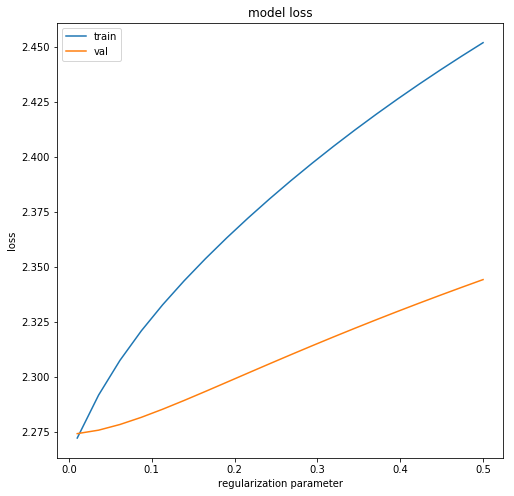

In [177]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,8)
plt.plot(reg_list , train_losses)
plt.plot(reg_list , val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('regularization parameter')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [179]:
best_model , best_loss = trainTrigram(x_train, y_train , 100 , 50 , 0)

In [180]:
best_loss

2.2631618976593018

In [181]:
print(evaluate_loss(model, x_dev , y_dev))

2.344167470932007


In [182]:
print(evaluate_loss(model, x_test , y_test))

2.331618070602417


In [ ]:
#We saw that our 1-hot vectors merely select a row of W, 
#so producing these vectors explicitly feels wasteful.
#Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

In [197]:
xs , ys = [] , []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs , chs[1:] , chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append((ix1, ix2))
        ys.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [198]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27 * 2 , 27), generator=g)

In [202]:
xs.shape , W.shape

(torch.Size([196113, 2]), torch.Size([54, 27]))

In [200]:
xs_oneh = F.one_hot(torch.tensor(xs), num_classes = 27).float()
xs_oneh = xs_oneh.flatten(1)

C:\Users\Manas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [220]:
xs_oneh @ W

tensor([[ 0.5352,  0.2418, -0.2616,  ..., -1.6675,  0.6432,  1.0764],
        [ 0.8098,  1.5744,  0.0988,  ..., -0.9052, -0.2371,  3.2653],
        [ 0.5310,  1.1447,  0.4153,  ...,  1.0670,  2.4894,  1.5959],
        ...,
        [ 0.3543,  0.8678,  0.0411,  ..., -1.8267,  1.9362, -0.1628],
        [ 0.4902, -1.4578,  0.0746,  ..., -0.0480,  0.8478, -1.1147],
        [ 1.5952, -0.6920, -0.7784,  ..., -1.5724,  0.8434, -0.9350]])

In [213]:
xs[: , 0]

tensor([ 0,  5, 13,  ..., 26, 25, 26])

In [212]:
xs[: , 1]

tensor([ 5, 13, 13,  ..., 25, 26, 24])

In [240]:
W[xs[: , 0]] + W[xs[: , 1]+27] # first half is first character , second half for the second character

tensor([[ 0.5352,  0.2418, -0.2616,  ..., -1.6675,  0.6432,  1.0764],
        [ 0.8098,  1.5744,  0.0988,  ..., -0.9052, -0.2371,  3.2653],
        [ 0.5310,  1.1447,  0.4153,  ...,  1.0670,  2.4894,  1.5959],
        ...,
        [ 0.3543,  0.8678,  0.0411,  ..., -1.8267,  1.9362, -0.1628],
        [ 0.4902, -1.4578,  0.0746,  ..., -0.0480,  0.8478, -1.1147],
        [ 1.5952, -0.6920, -0.7784,  ..., -1.5724,  0.8434, -0.9350]])